In [20]:
import numpy as np
import time
# PyTorch
import torch
print(torch.__version__)
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from matplotlib.pyplot import cm


1.5.0+cu101


In [0]:
class VSAM(torch.nn.Module):
    def __init__(self, D, H_LSTM, D_z,T,Noise_Std,Num_Samples):
        super(VSAM, self).__init__()
        self.Num_Test_Samples = Num_Samples
        self.Num_Samples = Num_Samples
        self.Noise_Std=Noise_Std
        self.Softmax = nn.Softmax(dim=1)
        self.H_LSTM = H_LSTM
        self.SqrtH = np.sqrt(2*H_LSTM)
        self.T=T
        self.D_z=D_z
        self.D=D
        self.Encoder = nn.LSTM(D,H_LSTM,1,True,False,0,True) # Deafult tanh activation as needed
        self.LinearMuZ = torch.nn.Linear(H_LSTM*2, D_z)
        self.LinearSigmaZ = torch.nn.Linear(H_LSTM*2, D_z)
        self.LinearSigmaCt= torch.nn.Linear(H_LSTM*2,D_z)
        self.LinearMuCt= torch.nn.Linear(H_LSTM*2,D_z)
        self.LinearDecoderMu = torch.nn.Linear(H_LSTM*2,D)
        self.LinearDecoderB = torch.nn.Linear(H_LSTM*2,D)
        self.SoftPlusActivation = torch.nn.Softplus() #Cannot see the parameters in the paper, so going with deafult for now.
        self.Decoder = nn.LSTM(2*D_z,H_LSTM,1,True,False,0,True) # Deafult tanh activation as needed

    def forward(self, x):
        data=x.clone()
        if self.training: # Setting mode, if input needs noise for regularization during training + numsamples should be 1 doing training for now(as it is in paper)
          data+=torch.randn(data.size()) *torch.std(data)*self.Noise_Std
          self.Num_Samples=1 
        else:
          self.Num_Samples=self.Num_Test_Samples
        miniBatchSize=list(data.size())[1]
        Encoder_Output, Hidden=self.Encoder(data) # Running the Encoder LSTM

        #Reforming variable from the LSTM output as needed
        hidden_sizes=list(Encoder_Output.size())
        Hidden_Transformed = Encoder_Output.view(hidden_sizes[0],hidden_sizes[1],2,int(hidden_sizes[2]/2)).transpose(0,1).transpose(1,3)
        Scores = torch.Tensor(miniBatchSize,self.T,self.T)
        Attention = torch.Tensor(miniBatchSize,self.T,self.T)
        Cdet = torch.zeros(miniBatchSize,self.H_LSTM,self.T,2)
        h=Encoder_Output.transpose(0,1)

        #Calculation the attention over the whole batch
        for i in range(self.T):
          Scores[:,i,:]=torch.bmm(h[:,i,:].clone().view(miniBatchSize,1,self.H_LSTM*2),h.transpose(1,2)).view(miniBatchSize,self.T)
        Scores/=self.SqrtH
        Attention=self.Softmax(Scores)

        #Calculating Cdet over the whole batch, for the backwards and forwards direction of the LSTM
        Cdet[:,:,:,0] = torch.bmm(Hidden_Transformed[:,:,0,:],Attention)
        Cdet[:,:,:,1] = torch.bmm(Hidden_Transformed[:,:,1,:],Attention)

        #Calculating the C's for all time points for the whole batch
        C=torch.empty(miniBatchSize,self.T,self.D_z).normal_(mean=0,std=1)
        CMu = torch.Tensor(miniBatchSize,self.T,self.D_z)
        CSigma = torch.Tensor(miniBatchSize,self.T,self.D_z)
        for i in range(self.T): # Looping over the timepoints since we have to run the linear networks for each timepoint with the same weights
          CdetInput=Cdet[:,:,i,:].reshape(miniBatchSize,self.H_LSTM*2)        
          CMu[:,i,:]=self.LinearMuCt(CdetInput)
          CSigma[:,i,:]=self.SoftPlusActivation(self.LinearSigmaCt(CdetInput))
        #Scaling the standard normal by the calculated Mu and Sigma from the linear layer.
        C=torch.mul(C,CSigma)
        C=torch.add(C,CMu)
        
        #Setting up the linear layer for the latent space
        LinearInput=Encoder_Output[self.T-1,:,:]
        MuZ = self.LinearMuZ(LinearInput)
        SigmaZ = self.SoftPlusActivation(self.LinearSigmaZ(LinearInput))

        #Creating all the latent samples and scaling with the calculated Mu and Sigma
        LatentSamples=torch.Tensor(miniBatchSize,self.Num_Samples,self.D_z)
        for i in range(self.Num_Samples):
          LatentSamples[:,i,:]=torch.add(torch.mul( torch.empty(miniBatchSize,self.D_z).normal_(mean=0,std=1),SigmaZ),MuZ)


        #Setting up for the decoder LSTM
        LaplaceMu=torch.Tensor(self.T,miniBatchSize,self.Num_Samples,self.D)
        LaplaceB=torch.Tensor(self.T,miniBatchSize,self.Num_Samples,self.D)
        for i in range(self.Num_Samples): # Have to run the decoder LSTM for each sample
          DecoderInput=torch.Tensor(self.T,miniBatchSize,2*self.D_z)
          for j in range(self.T): # Setting up the input for the decoder
            DecoderInput[j,:,:]=torch.cat((LatentSamples[:,i,:],C[:,j,:]),1)
          Decoder_Output, Hidden =  self.Decoder(DecoderInput)
          for j in range(self.T): # Running the same linear layer on every timepoint of the output of the decoder LSTM
            LaplaceMu[j,:,i,:]=self.LinearDecoderMu(Decoder_Output[j,:,:].reshape(miniBatchSize,self.H_LSTM*2))
            LaplaceB[j,:,i,:]=self.SoftPlusActivation(self.LinearDecoderB(Decoder_Output[j,:,:].reshape(miniBatchSize,self.H_LSTM*2)))

        if self.training: # Return the correct things depending if training of evaluating the network
          return CMu,CSigma,MuZ,SigmaZ,LaplaceMu,LaplaceB,LatentSamples,C #Return all the things needed for the loss function
        else:
          return LaplaceMu,LaplaceB,LatentSamples # Return things needed for Reconstruction Probablaity  Score
        



In [0]:
def VSAM_loss(VSAM_output, VSAM_input,deltaKL,eta): 
  #Getting all the dimensions from the data
  CMu=VSAM_output[0]
  CSigma=VSAM_output[1]
  MuZ=VSAM_output[2]
  SigmaZ=VSAM_output[3]
  LaplaceMu=VSAM_output[4]
  LapalceB=VSAM_output[5]
  LatentSamples=VSAM_output[6]
  C=VSAM_output[7]
  T=list(LaplaceMu.size())[0]
  miniBatchSize=list(LaplaceMu.size())[1]
  Num_Samples=list(LaplaceMu.size())[2]
  D=list(LaplaceMu.size())[3]
  D_z=list(LatentSamples.size())[2]
  #Setting up the loss variables
  loss = torch.zeros(1)
  loss1 = torch.zeros(1)
  loss2 = torch.zeros(1)
  loss3 = torch.zeros(1)
  #Defining some probability functions
  KLDivLoss=torch.nn.KLDivLoss(reduction="sum")
  standardNormal=torch.distributions.normal.Normal(torch.zeros(miniBatchSize,D_z),torch.ones(miniBatchSize,D_z))
  normalqz=torch.distributions.normal.Normal(MuZ, SigmaZ)
  for j in range(Num_Samples): # For the two parts of the loss that depend on the samples, calcluate it for each sample
    #Loss 1
    laplace=torch.distributions.laplace.Laplace(LaplaceMu[:,:,j,:],LapalceB[:,:,j,:])
    #laplace=torch.distributions.normal.Normal(LaplaceMu[:,:,j,:],LapalceB[:,:,j,:])
    loss1 +=(-torch.sum(laplace.log_prob(VSAM_input)))/(T*D)
    #Loss 2
    a2=normalqz.log_prob(LatentSamples[:,j,:])
    b2=torch.exp(standardNormal.log_prob(LatentSamples[:,j,:]))
    loss2+=KLDivLoss(a2,b2)/(D_z)
  loss1/=Num_Samples
  loss2/=Num_Samples
  #Loss 3
  for k in range(T): # For the Ct loss part, calculate it for each t.
    normalct=torch.distributions.normal.Normal(CMu[:,k,:],CSigma[:,k,:])
    a3=normalct.log_prob(C[:,k,:])
    b3=torch.exp(standardNormal.log_prob(C[:,k,:]))
    loss3+=KLDivLoss(a3,b3)/(D_z)
  loss= loss1+deltaKL*(loss2+eta*loss3)
  return loss

In [0]:
def Reconstruction_Probability_Score(VSAM_output, VSAM_input):
  #Getting all the dimensions from the data
  LaplaceMu=VSAM_output[0]
  LapalceB=VSAM_output[1]
  T=list(LaplaceMu.size())[0]
  miniBatchSize=list(LaplaceMu.size())[1]
  Num_Samples=list(LaplaceMu.size())[2]
  D=list(LaplaceMu.size())[3]
  RPS=torch.zeros(miniBatchSize)
  for j in range(Num_Samples): # Calculate the Reconstruction_Probability_Score for each sample
        #laplace=torch.distributions.normal.Normal(LaplaceMu[:,:,j,:],LapalceB[:,:,j,:])
        laplace=torch.distributions.laplace.Laplace(LaplaceMu[:,:,j,:],LapalceB[:,:,j,:])
        RPS+=torch.sum(laplace.log_prob(VSAM_input),dim=[0,2])/(T*D) # Could maybe save these instead, you have a number for every timestep in the series instead of the average
  return RPS/Num_Samples # Return the mean Reconstruction_Probability_Score

In [0]:
def Trainer(dataloader,InputDim,T,miniBatchSize,Epochs,Hidden_LSTM,Latent_Dim,AddedInputNoise,Learning_Rate,betas,eps,weight_decay,clip_gradient_max_norm,deltaKLMax,deltaKLStart,DeltaKLEnd,eta):#Maybe Num samples later
  model=VSAM(InputDim,Hidden_LSTM,Latent_Dim,T,AddedInputNoise,10) # Maybe chance 10 to num samples later
  model.train()
  optimizer=torch.optim.Adam(model.parameters(),lr=Learning_Rate,betas=betas,eps=eps,weight_decay=weight_decay,amsgrad=True) # Setup the optimizer
  lossPrint=0
  lossPlot=[]
  deltaKL=0
  t=time.time()
  for epoch in range(Epochs): # The loop over Epochs
    for i_batch, sample_batched in enumerate(dataloader): #The loop over minibatches
      minibatch=sample_batched.transpose(0,1)
      if i_batch==0: # Calculate deltaKL according to KL-anealing scheme at the start of each batch, also output the loss of the last batch.
        #printSample=minibatch[:,0,:].view(200,1,1)
        #Reconstruction(printSample,model)
        deltaKL=min(max((deltaKLMax/(DeltaKLEnd-deltaKLStart))*(epoch-deltaKLStart),0),deltaKLMax)
        if epoch>0:
          lossPlot.append(lossPrint)
        print("Epoch: ",epoch," Time: ",time.time()-t," Loss: ",lossPrint)
        lossPrint=0
      optimizer.zero_grad() # Remove the gradients of the last batch
      output=model.forward(minibatch) #Forward run of the model
      for a in output: # Check if there is any nan values in the output of the model, and thereby there is an error in the model 
        assert not torch.isnan(a).any()
      loss=VSAM_loss(output, minibatch,deltaKL,eta) # Calculate the loss of the minibatch
      lossPrint+=loss.data # store the loss of the whole epoch
      loss.backward() # Do the backwards propergation to calculate the gradients 
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_gradient_max_norm) # Clip the gradient as a regularization technique 
      optimizer.step()   # Do the optimizer step 
  lossPlot.append(lossPrint)
  plt.plot(lossPlot)
  torch.save(model.state_dict(), "model")
  return model



---



(10219, 200, 1)
(1469, 200, 1)


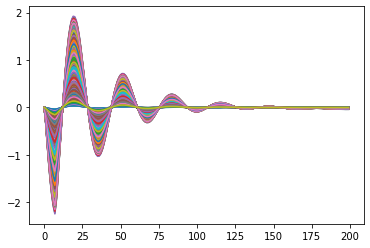

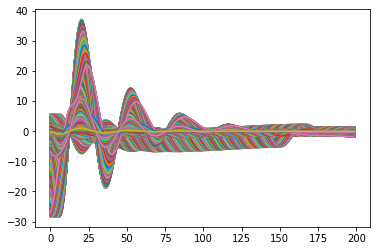

<Figure size 432x288 with 0 Axes>

In [6]:
Anomaly=np.load("Anomaly.npy")
NormalState=np.load("NormalState.npy")
np.random.shuffle(NormalState)
print(np.shape(Anomaly))
print(np.shape(NormalState))
meanNormal=np.mean(NormalState)
meanAbnormal=np.mean(Anomaly)
MeanScaler=np.abs(meanAbnormal/meanNormal)
fig1=plt.figure()
for i in range(1469):
  plt.plot(NormalState[i,:,:])
plt.show()
fig2=plt.figure()
for i in range(10219):
  plt.plot(Anomaly[i,:,:])
plt.show()
fig4=plt.figure()

Epoch:  0  Time:  0.03158998489379883  Loss:  0
Epoch:  1  Time:  49.03787302970886  Loss:  tensor([407.9862])
Epoch:  2  Time:  98.86031937599182  Loss:  tensor([-103.3158])
Epoch:  3  Time:  148.41229605674744  Loss:  tensor([-534.5765])
Epoch:  4  Time:  197.53183603286743  Loss:  tensor([-903.0986])
Epoch:  5  Time:  246.9975278377533  Loss:  tensor([-1132.4694])
Epoch:  6  Time:  296.1999900341034  Loss:  tensor([-1262.6735])
Epoch:  7  Time:  345.4959030151367  Loss:  tensor([-1311.6046])
Epoch:  8  Time:  394.7205009460449  Loss:  tensor([-1352.0839])
Epoch:  9  Time:  443.84957337379456  Loss:  tensor([-1400.5806])
Epoch:  10  Time:  493.4629418849945  Loss:  tensor([-1446.7827])
Epoch:  11  Time:  542.8694868087769  Loss:  tensor([-1513.1003])
Epoch:  12  Time:  592.6668629646301  Loss:  tensor([-1467.2483])
Epoch:  13  Time:  642.4104173183441  Loss:  tensor([-1552.3397])
Epoch:  14  Time:  692.0246946811676  Loss:  tensor([-1504.9065])
Epoch:  15  Time:  741.0685257911682  L

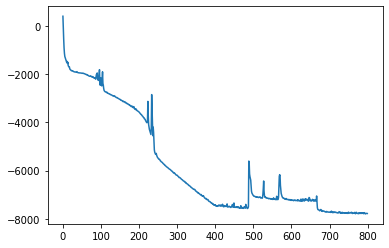

In [0]:

Traindata=NormalState[0:1000,:,:]
Traindata=torch.Tensor(Traindata)
TestData=np.concatenate((NormalState[1000:1469,:,:],Anomaly),axis=0)
minibatchsize=25 # tested this, less than this does not fully represent the dataset
dataloader=DataLoader(Traindata, batch_size=minibatchsize,shuffle=True)
trainedModel=Trainer(dataloader,1,200,minibatchsize,800,30,1,0.1,0.001,(0.9,0.999),1e-08,0,1,0.25,50,400,0.005) # try latent dim of 1, since only difference is in the mean value
print("Done")

In [42]:
#Use this if you are loading a model
Traindata=NormalState[0:1000,:,:]
Traindata=torch.Tensor(Traindata)
TestData=np.concatenate((NormalState[1000:1469,:,:],Anomaly),axis=0)
trainedModel=VSAM(1,30,1,200,0.1,10)
trainedModel.load_state_dict(torch.load("Laplacemodel"))

<All keys matched successfully>

In [0]:
TestData=torch.Tensor(TestData).transpose(0,1)

In [44]:
trainedModel.eval() # To set model to test mode
AnomalySample=TestData[:,500:520,:]
CorrectSample=TestData[:,0:20,:]
output=trainedModel.forward(CorrectSample)
print(Reconstruction_Probability_Score(output, CorrectSample))
output2=trainedModel.forward(AnomalySample)
print(Reconstruction_Probability_Score(output2, AnomalySample))
RPS=[]
for i in range(100):
  output=trainedModel.forward(TestData[:,i*100:(i+1)*100,:])
  RPS.extend(Reconstruction_Probability_Score(output, TestData[:,i*100:(i+1)*100,:]).tolist())
output=trainedModel.forward(TestData[:,10000:10219,:])
RPS.extend(Reconstruction_Probability_Score(output, TestData[:,10000:10219,:]).tolist())

tensor([3.4560, 3.4924, 3.4389, 3.5059, 3.7218, 3.6915, 3.4487, 3.4948, 3.2183,
        3.4324, 3.4270, 3.8491, 3.7191, 3.5890, 3.2521, 3.7062, 2.5801, 3.4431,
        3.5009, 3.4483], grad_fn=<DivBackward0>)
tensor([3.4191, 3.4319, 3.4483, 3.4434, 3.4434, 3.4161, 3.4302, 3.3995, 3.5602,
        3.3995, 3.3540, 3.3715, 3.3029, 3.3029, 3.1974, 3.2026, 3.0785, 3.0785,
        2.9705, 3.5602], grad_fn=<DivBackward0>)


0.9548559400798207


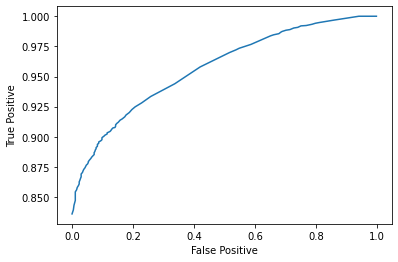

In [45]:
length=len(RPS)
NumPoints=100
FP=np.zeros((NumPoints+1,1))
TP=np.zeros((NumPoints+1,1))
minBorder=min(RPS[0:469])
maxBorder=max(RPS)
for j in range(NumPoints+1):
  number=minBorder+j*(maxBorder-minBorder)/NumPoints
  WrongNormal=0
  WrongAnomaly=0
  WrongTotal=0
  for i in range(length):
    if i<469 and RPS[i]<number:
      WrongNormal+=1
    if i>=469 and RPS[i]>=number:
      WrongAnomaly+=1
  FP[j]=WrongNormal/469
  TP[j]=1-WrongAnomaly/(length-469)
plt.plot(FP,TP)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
print(auc(FP,TP)) # Baseline using random initialized weights = 0.2629 - basicly its super bad.

In [0]:
def Reconstruction(Input,model):
    model.eval() # To set model to test mode
    Output=model.forward(Input)
    LaplaceMu=Output[0]
    LapalceB=Output[1]
    T=list(LaplaceMu.size())[0]
    miniBatchSize=list(LaplaceMu.size())[1]
    Num_Samples=list(LaplaceMu.size())[2]
    D=list(LaplaceMu.size())[3]
    LaplaceMu=LaplaceMu
    LapalceB=LapalceB
    Input=Input.view(T)
    figure=plt.figure()
    plt.plot(Input.data.numpy(),color="green")
    color=iter(cm.rainbow(np.linspace(0,1,Num_Samples)))
    for i in range(Num_Samples):
      c=next(color)
      plt.plot(LaplaceMu[:,0,i,0].data.numpy(),color=c)
    plt.show()
    model.train()

In [0]:
def PlotLatentSpace(Input,model):
  model.eval() # To set model to test mode
  fig=plt.figure()
  Output=model.forward(Input[:,469:1000,:])
  LatentSamples=Output[2].view(-1,1).detach().numpy()
  plt.scatter(LatentSamples,np.ones(len(LatentSamples)),color="red")
  for i in range(10,100):
    Output=model.forward(Input[:,i*100:(i+1)*100,:])
    LatentSamples=Output[2].view(-1,1).detach().numpy()
    plt.scatter(LatentSamples,np.ones(len(LatentSamples)),color="red")
  Output=model.forward(Input[:,10000:10219,:])
  LatentSamples=Output[2].view(-1,1).detach().numpy()
  plt.scatter(LatentSamples,np.ones(len(LatentSamples)),color="red")
  Output=model.forward(Input[:,0:469,:])
  LatentSamples=Output[2].view(-1,1).detach().numpy()
  plt.scatter(LatentSamples,np.zeros(len(LatentSamples)),color="green")
  plt.xlabel('Latent Dimension')
  plt.ylabel('NormalState/Anomaly')

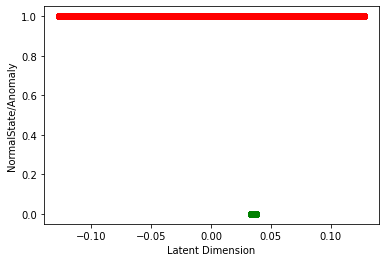

In [46]:
PlotLatentSpace(TestData,trainedModel)

In [47]:
print(min(RPS[0:469]))
print(np.argmin(RPS[0:469]))
print(max(RPS))
print(np.argmax(RPS))

2.4895987510681152
53
3.8518099784851074
98


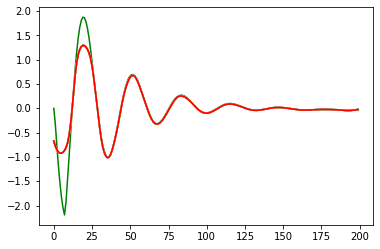

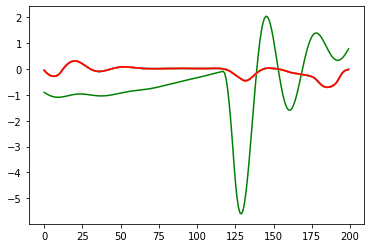

In [48]:
# To set model to test mode
CorrectReconstructionSample=TestData[:,53:54,:]
AnomalyReconstructionSample=TestData[:,6170:6171,:]
Reconstruction(CorrectReconstructionSample,trainedModel)
Reconstruction(AnomalyReconstructionSample,trainedModel)
#for i in range(0,20):
#  CorrectReconstructionSample=TestData[:,i:(i+1),:]
#  Reconstruction(CorrectReconstructionSample,trainedModel)